In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
dev = qml.device("default.qubit", wires = 2)

In [4]:
@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=1)
    qml.CNOT(wires=[1,0])
    qml.RY(theta,wires=0)
    
    return qml.expval(qml.PauliZ(wires=0))

In [5]:
print(circuit(np.pi))

1.0


In [6]:
import matplotlib.pyplot as plt

In [7]:
thetas = np.arange(-np.pi, np.pi,0.01)

In [8]:
measurements = np.zeros(len(thetas))

In [9]:
for i,theta in enumerate(thetas):
    measurements[i] = circuit(theta)

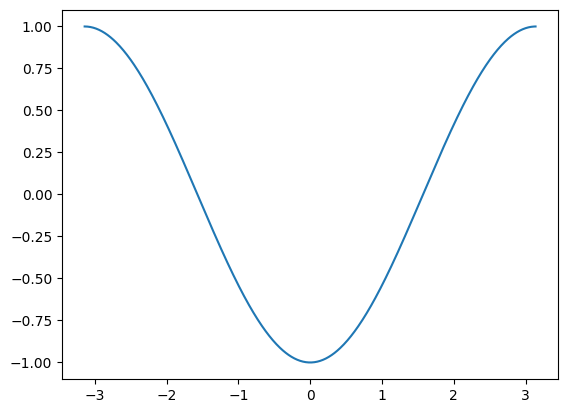

In [10]:
plt.plot(thetas,measurements)
plt.show()

## Pennylane Devices Introduction

In [2]:
import pennylane as qml

dev = qml.device("default.qubit",wires = 1)
#dev = qml.device("lightning.qubit",wires = 1) # uses c++
#dev = qml.device("default.mixed",wires = 1)   # If you want to use mixed state

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires = 0)
    return qml.probs(wires=0)
circuit()

tensor([0.5, 0.5], requires_grad=True)

In [3]:
dev = qml.device("default.gaussian",wires = 1) # uses qmode

## Optimizing quantum circuits

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [5]:
dev = qml.device('lightning.qubit', wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=0)
    qml.RY(theta,wires=0)
    return qml.expval(qml.PauliZ(0))
circuit(0.1)

array(-0.99500417)

In [6]:
thetas = np.linspace(-np.pi,np.pi,50)
measurements = []
for theta in thetas:
    measurements.append(circuit(theta))

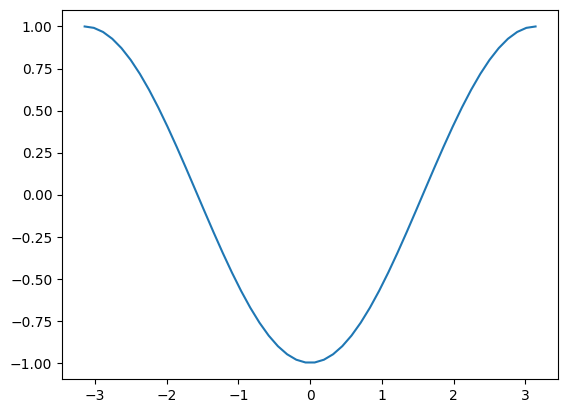

In [7]:
fig,ax = plt.subplots()
ax.plot(thetas,measurements)
plt.show()

In [8]:
theta = np.array([-2],requires_grad=True)

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [10]:
n_it = 101
for it in range(n_it):
    theta,prev_cost = opt.step_and_cost(circuit,theta)
    if it%10==0:
        print('Theta: ',theta,' Cost: ',circuit(theta))

Theta:  [-2.]  Cost:  0.4161468365471423
Theta:  [-1.03886544]  Cost:  -0.507198377134105
Theta:  [-0.39883261]  Cost:  -0.9215149712781964
Theta:  [-0.14098266]  Cost:  -0.9900783947884957
Theta:  [-0.0492414]  Cost:  -0.9987878872207129
Theta:  [-0.01717298]  Cost:  -0.9998525480120855
Theta:  [-0.005988]  Cost:  -0.9999820719882673
Theta:  [-0.00208789]  Cost:  -0.9999978203532067
Theta:  [-0.000728]  Cost:  -0.9999997350055523
Theta:  [-0.00025384]  Cost:  -0.9999999677828575
Theta:  [-8.85082198e-05]  Cost:  -0.9999999960831475


## Differentation on quantum hardware

In [2]:
import pennylane as qml
from pennylane import numpy as np

np.set_printoptions(precision=10)

In [6]:
dev = qml.device("default.qubit",wires =2)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RX(params[1], wires = 1)
    return qml.expval(qml.PauliZ(0)+qml.PauliZ(1))

In [7]:
params = np.array([np.pi/4,np.pi/4])
print(circuit(params))

1.414213562373095


In [9]:
def my_finite_diff_grad(params, h = 1e-7):
    gradient = np.zeros_like(params)
    
    for i in range(len(params)):
        params[i] +=h
        gradient[i] += circuit(params)
        
        params[i] -=2*h
        gradient[i] -= circuit(params)
        
        gradient[i] /=2*h
        
        params[i] +=h
        
    return gradient

In [21]:
@qml.qnode(dev, diff_method="finite-diff")
def circuit_finite_diff(params):
    qml.RY(params[0], wires = 0)
    qml.RX(params[1], wires = 1)
    return qml.expval(qml.PauliZ(0)+qml.PauliZ(1))

In [22]:
params = np.array([np.pi/4,np.pi/3],requires_grad = True)

print(my_finite_diff_grad(params))
print(qml.grad(circuit_finite_diff)(params))

[-0.7071067798 -0.8660254025]
[-0.7071068131 -0.8660254314]


In [23]:
def my_parameter_shift_grad(params, s = np.pi/3):
    gradient = np.zeros_like(params)
    
    for i in range(len(params)):
        params[i] +=s
        gradient[i] += circuit(params)
        
        params[i] -=2*s
        gradient[i] -= circuit(params)
        
        gradient[i] /=2*np.sin(s)
        
        params[i] +=s
        
    return gradient

In [24]:
@qml.qnode(dev,diff_method="parameter-shift")
def circuit_parameter_shift(params):
    qml.RY(params[0], wires = 0)
    qml.RX(params[1], wires = 1)
    return qml.expval(qml.PauliZ(0)+qml.PauliZ(1))

In [25]:
print(my_parameter_shift_grad(params))
print(qml.grad(circuit_parameter_shift)(params))

[-0.7071067812 -0.8660254038]
[-0.7071067812 -0.8660254038]


### Quantum chemistry

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

In [12]:
symbols = ["H","H"]
coordinates = np.array([[-0.673,0,0],[0.673,0,0]])

In [13]:
H, qubits = qchem.molecular_hamiltonian(symbols, coordinates)
print(qubits)

4


In [14]:
print(H)

  (-0.23663556589795115) [Z2]
+ (-0.23663556589795115) [Z3]
+ (-0.059722777506507174) [I0]
+ (0.17574790106889876) [Z0]
+ (0.17574790106889876) [Z1]
+ (0.12222295790716331) [Z0 Z2]
+ (0.12222295790716331) [Z1 Z3]
+ (0.16714112448986262) [Z0 Z3]
+ (0.16714112448986262) [Z1 Z2]
+ (0.1700120046062239) [Z0 Z1]
+ (0.1756999882843957) [Z2 Z3]
+ (-0.044918166582699315) [Y0 Y1 X2 X3]
+ (-0.044918166582699315) [X0 X1 Y2 Y3]
+ (0.044918166582699315) [Y0 X1 X2 Y3]
+ (0.044918166582699315) [X0 Y1 Y2 X3]


In [6]:
num_wires = qubits
dev = qml.device("default.qubit",wires = num_wires)

@qml.qnode(dev)
def exp_energy(state):
    qml.BasisState(np.array(state),wires = range(num_wires))
    return qml.expval(H)

In [7]:
exp_energy([1,0,1,0])

tensor(-0.4952711, requires_grad=True)

In [9]:
hf = qchem.hf_state(electrons = 2, orbitals = 4)

In [10]:
exp_energy(hf)

tensor(-1.11750588, requires_grad=True)